In [1]:
import pandas as pd
import numpy as np
np.float_ = np.float64
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
import cryptocompare
import requests
import ssl
from typing import Optional
from itertools import product
from tqdm import tqdm
from holidays.holiday_base import HolidayBase
import lightgbm as lgb
from optuna.integration.lightgbm import Dataset
from prophet import Prophet
import re
import prophet
import math
import pickle
import joblib
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from sklearn.model_selection import train_test_split
import optuna
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse
#import pmdarima as pm
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.graph_objs as go
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from nixtla import NixtlaClient
import warnings
warnings.filterwarnings("ignore")
import os

c:\Users\shivi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
end_date = datetime.now().strftime('%Y-%m-%d')
btc_data = cryptocompare.get_historical_price_day('BTC', currency='USD', toTs=datetime.now())
print(btc_data)

[{'time': 1614297600, 'high': 48438.38, 'low': 44153.46, 'open': 47082.87, 'volumefrom': 90519.05, 'volumeto': 4204800171.81, 'close': 46324.5, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1614384000, 'high': 48362.8, 'low': 45063.84, 'open': 46324.5, 'volumefrom': 39013.78, 'volumeto': 1831237567.32, 'close': 46191.39, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1614470400, 'high': 46645.9, 'low': 43061.92, 'open': 46191.39, 'volumefrom': 62249.5, 'volumeto': 2776726256.13, 'close': 45261.03, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1614556800, 'high': 49812.2, 'low': 45058.98, 'open': 45261.03, 'volumefrom': 65660.6, 'volumeto': 3146266419.71, 'close': 49635.07, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1614643200, 'high': 50221.14, 'low': 47097.84, 'open': 49635.07, 'volumefrom': 43281.84, 'volumeto': 2105387914.68, 'close': 48501.21, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1614729600, 

In [3]:
df = pd.DataFrame(btc_data)
df['time'] = pd.to_datetime(df['time'], unit='s')

In [4]:
df.rename(columns={
    'time': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volumeto': 'Volume'
}, inplace=True)

In [5]:
df['Adj Close'] = df['Close']

In [6]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]


It’s important to note that unlike traditional financial assets, Bitcoin trades 24/7. Therefore, the closing price represents the price of Bitcoin at a specific time each day, rather than at the end of a trading day.


In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

FACEBOOK PROPHET

In [8]:
data = df.copy()

# Change date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Take a look at the data
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-26,47082.87,48438.38,44153.46,46324.50,46324.50,4.204800e+09
1,2021-02-27,46324.50,48362.80,45063.84,46191.39,46191.39,1.831238e+09
2,2021-02-28,46191.39,46645.90,43061.92,45261.03,45261.03,2.776726e+09
3,2021-03-01,45261.03,49812.20,45058.98,49635.07,49635.07,3.146266e+09
4,2021-03-02,49635.07,50221.14,47097.84,48501.21,48501.21,2.105388e+09


In [9]:
# Declare a figure
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], 
                name = 'Bitcoin Data'))

In [10]:
# Keep only date and close price
df1 = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Rename date to ds and close price to y
df1.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Take a look at the data
df1.head()

,ds,y
0,2021-02-26,46324.50
1,2021-02-27,46191.39
2,2021-02-28,45261.03
3,2021-03-01,49635.07
4,2021-03-02,48501.21


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1441 non-null   datetime64[ns]
 1   y       1441 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.6 KB


In [12]:
df1.tail()

,ds,y
1436,2025-02-01,100619.87
1437,2025-02-02,97665.06
1438,2025-02-03,101451.28
1439,2025-02-04,97794.88
1440,2025-02-05,97861.38


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1441 non-null   datetime64[ns]
 1   y       1441 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.6 KB


<Axes: xlabel='ds'>

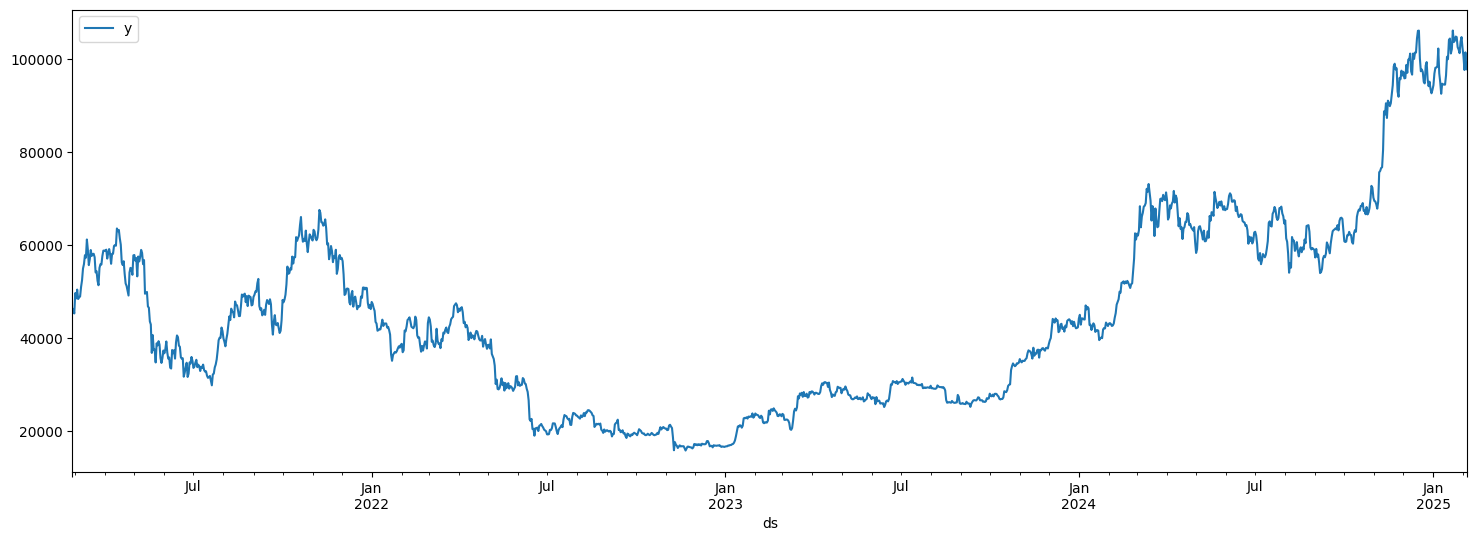

In [14]:
df1.plot(x='ds',y='y',figsize=(18,6))

In [15]:
train = df1.iloc[:-365,:]
train.shape

(1076, 2)

In [16]:
test = df1.iloc[-365:]
test.shape

(365, 2)

In [17]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (c:\Users\shivi\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\shivi\AppData\Local\Temp\tmpahjkpu6l\e90fa204.json
DEBUG:cmdstanpy:input tempfile: C:\Users\shivi\AppData\Local\Temp\tmpahjkpu6l\1a5o9v0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\shivi\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=47589', 'data', 'file=C:\\Users\\shivi\\AppData\\Local\\Temp\\tmpahjkpu6l\\e90fa204.json', 'init=C:\\Users\\shivi\\AppData\\Local\\Temp\\tmpahjkpu6l\\1a5o9v0a.json', 'output', 'file=C:\\Users\\shivi\\AppData\\Local\\Temp\\tmpahjkpu6l\\prophet_model9dc

In [18]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1436,2025-02-01,65853.743848,26986.221796,105043.942113,26562.005164,103646.945592,617.156230,617.156230,617.156230,-67.422216,-67.422216,-67.422216,684.578445,684.578445,684.578445,0.0,0.0,0.0,66470.900077
1437,2025-02-02,65917.737747,27614.652814,105175.292948,26497.125118,103892.091190,876.847831,876.847831,876.847831,-33.833990,-33.833990,-33.833990,910.681821,910.681821,910.681821,0.0,0.0,0.0,66794.585578
1438,2025-02-03,65981.731646,27521.446240,105582.103146,26446.845541,104081.047282,1144.353526,1144.353526,1144.353526,11.003931,11.003931,11.003931,1133.349594,1133.349594,1133.349594,0.0,0.0,0.0,67126.085172
1439,2025-02-04,66045.725546,27789.704862,106816.865458,26396.565965,104270.003374,1419.634619,1419.634619,1419.634619,71.599390,71.599390,71.599390,1348.035229,1348.035229,1348.035229,0.0,0.0,0.0,67465.360165
1440,2025-02-05,66109.719445,26956.028856,106744.366720,26346.286388,104458.959466,1674.424337,1674.424337,1674.424337,124.118765,124.118765,124.118765,1550.305572,1550.305572,1550.305572,0.0,0.0,0.0,67784.143782


In [19]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1436,2025-02-01,66470.900077,26986.221796,105043.942113
1437,2025-02-02,66794.585578,27614.652814,105175.292948
1438,2025-02-03,67126.085172,27521.446240,105582.103146
1439,2025-02-04,67465.360165,27789.704862,106816.865458
1440,2025-02-05,67784.143782,26956.028856,106744.366720


In [20]:
test.tail()

,ds,y
1436,2025-02-01,100619.87
1437,2025-02-02,97665.06
1438,2025-02-03,101451.28
1439,2025-02-04,97794.88
1440,2025-02-05,97861.38


In [21]:
plot_plotly(m, forecast)

In [22]:
plot_components_plotly(m, forecast)

In [23]:
predictions = forecast.iloc[-365:]['yhat']

In [24]:
rmse = rmse(predictions, test['y'])
print("Root Mean Squared Error between actual and predicted values : ", rmse)
print("Mean Value of Test Dataset :", test['y'].mean())

Root Mean Squared Error between actual and predicted values :  20270.84804821588
Mean Value of Test Dataset : 71648.11709589041


In [25]:
max = df1['y'].max()
min = df1['y'].min()

In [26]:
nrmse = rmse/(max-min)
nrmse

np.float64(0.22424640593755615)

In [27]:

#file_path = 'C:/Users/shivi/OneDrive/Desktop/My Projects/Sneha bitcoin prediction/prophet_model.pkl'

In [28]:
#pickle.dump(m, open(file_path, "wb"))

81.68% of Accuracy for FB PROPHET Model

ARIMA

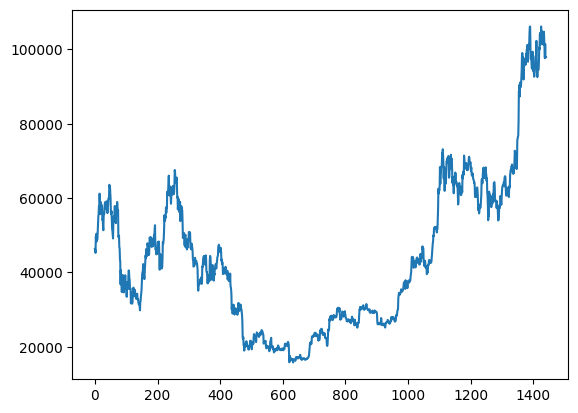

In [29]:
plt.plot(df.index, df['Close'])
plt.show()

In [30]:
to_row = int(len(df)*0.9)

train_data = list(df[0:to_row]['Close'])
test_data = list(df[to_row:]['Close'])

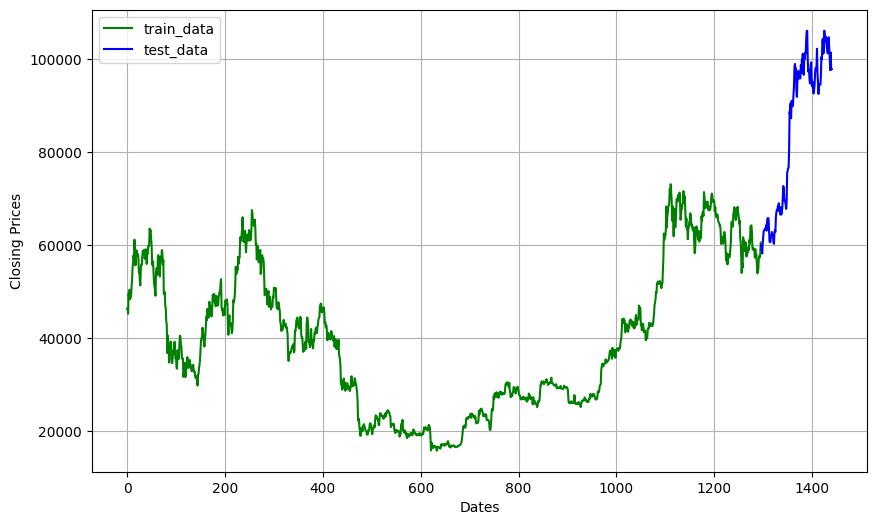

In [31]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel("Dates")
plt.ylabel("Closing Prices")
plt.plot(df[0:to_row]['Close'],'green',label='train_data')
plt.plot(df[to_row:]['Close'],'blue',label = "test_data")
plt.legend()

In [32]:
model_predictions = []
n_test_obser = len(test_data)

model = pm.auto_arima(df['Close'], 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

In [33]:
#Best model:  ARIMA(2,1,3)(2,0,2)[12]

for i in range(n_test_obser):
    model = ARIMA(train_data, order = (2,1,3))
    model_fit=model.fit()
    output = model_fit.forecast()
    yhat = [output[0]]
    model_predictions.append(yhat)
    actual_test_value = test_data[i]
    train_data.append(actual_test_value)

In [34]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1440
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -12521.153
Date:                Wed, 05 Feb 2025   AIC                          25054.307
Time:                        14:51:57   BIC                          25085.937
Sample:                             0   HQIC                         25066.115
                               - 1440                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0164      0.062      0.264      0.792      -0.105       0.138
ar.L2          0.8646      0.063     13.817      0.000       0.742       0.987
ma.L1         -0.0545      0.063     -0.862      0.389      -0.178       0.069
ma.L2         -0.8757      0.063    -13.919      0.000      -0.999      -0.752
ma.L3          0.0707      0.020      3.500      0.000       0.031       0.110
sigma2      2.118e+06   4.69e+04     45.127      0.000    2.03e+06    2.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               829.53
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.08
Prob(H) (two-sided):                  0.28   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

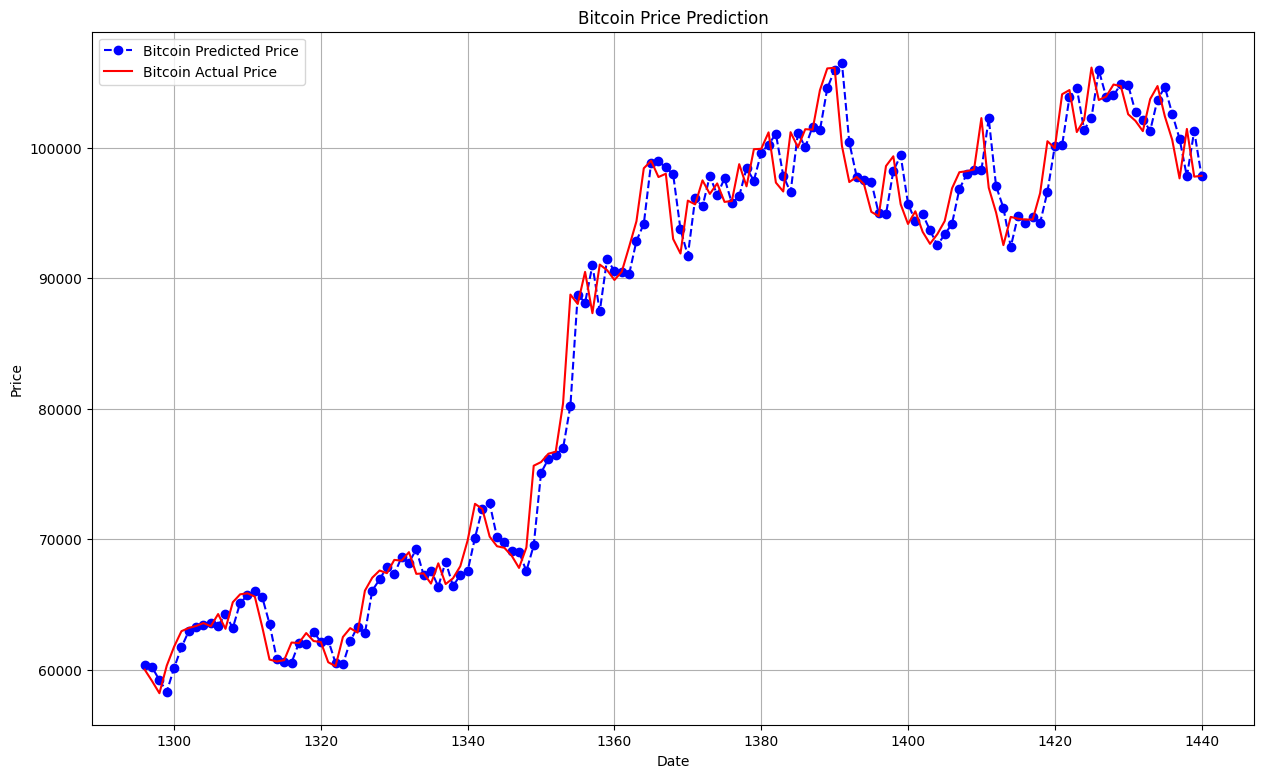

In [35]:
plt.figure(figsize=(15,9))
plt.grid(True)
date_range = df[to_row:].index
plt.plot(date_range, model_predictions, color = "blue" , marker = 'o', linestyle = 'dashed', label = "Bitcoin Predicted Price")
plt.plot(date_range, test_data, color = 'red', label = 'Bitcoin Actual Price')
plt.title("Bitcoin Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [36]:
mape = np.mean(np.abs(np.array(model_predictions[:-1]) - np.array(test_data))/np.abs(test_data))
print("MAPE: ", str(mape))

MAPE:  0.22625529815017995


This is generally considered excellent accuracy in time series forecasting as it means that, on average, your model's predictions are within about 7.94% of the actual values.

In [37]:
#model_path = os.path.join(r'C:\Users\shivi\OneDrive\Desktop\My Projects\Sneha bitcoin prediction', 'arima_model.pkl')

In [ ]:
#joblib.dump(model_fit,model_path)

['C:\\Users\\shivi\\OneDrive\\Desktop\\My Projects\\Sneha bitcoin prediction\\arima_model.pkl']

69% of Accuracy for ARIMA Model

LSTM

In [39]:
df2 = df.reset_index()['Close']
df2

0        46324.50
1        46191.39
2        45261.03
3        49635.07
4        48501.21
          ...    
1436    100619.87
1437     97665.06
1438    101451.28
1439     97794.88
1440     97861.38
Name: Close, Length: 1441, dtype: float64

In [40]:
df2.shape

(1441,)

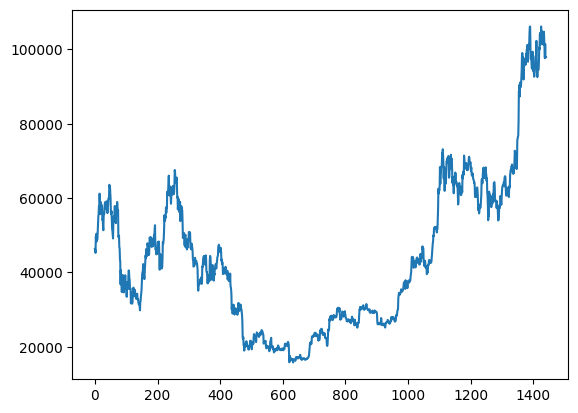

In [41]:
plt.plot(df2)

In [42]:
#LSTM are sensitive to the scale of the data, so we apply MinMax Scaler
scaler = MinMaxScaler(feature_range=(0,1))
df3 = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [43]:
df3.shape

(1441, 1)

In [44]:
#Spliiting dataset into train(70% of data) and test split(30% of data)
training_size = int(len(df3)*0.65)
test_size = len(df3) - training_size
train_data,test_data = df3[0:training_size,:],df3[training_size:len(df3),:1]

In [45]:
training_size,test_size

(936, 505)

In [46]:
#Converting an array of values into a dataset matrix
#Timesteps = How many number of previous days data we should consider to make prediction for the next data 
def create_dataset(dataset,time_steps=1):
    dataX,dataY = [] , []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [47]:
time_step = 100 #Timestamp
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [48]:
print(X_train)

[[0.3381179  0.33664537 0.32635326 ... 0.25963118 0.2334334  0.21879659]
 [0.33664537 0.32635326 0.37474111 ... 0.2334334  0.21879659 0.22167473]
 [0.32635326 0.37474111 0.36219778 ... 0.21879659 0.22167473 0.19716342]
 ...
 [0.11890979 0.11863013 0.11168696 ... 0.11579458 0.11918159 0.11997621]
 [0.11863013 0.11168696 0.11258745 ... 0.11918159 0.11997621 0.11957398]
 [0.11168696 0.11258745 0.11223412 ... 0.11997621 0.11957398 0.11917562]]


In [49]:
print(X_test.shape), print(ytest.shape)

(404, 100)
(404,)


(None, None)

In [50]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [51]:
model = Sequential() #One LSTM after the another LSTM is Stacked LSTM
model.add(LSTM(50,return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.fit(X_train, y_train, validation_data = (X_test,ytest), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - loss: 0.0280 - val_loss: 0.0766
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.0052 - val_loss: 0.0079
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 9.6725e-04 - val_loss: 0.0025
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 9.4137e-04 - val_loss: 0.0033
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 8.3159e-04 - val_loss: 0.0031
Epoch 12/100
14/14 ━━━━━━━━━

In [54]:
#model.save(r"C:\\Users\\shivi\\OneDrive\\Desktop\\My Projects\\Sneha bitcoin prediction\\lstm_model.h5")

In [55]:
#Prediction and checking performance Metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [56]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [57]:
#Train Data RMSE
math.sqrt(mean_squared_error(y_train,train_predict))

34938.20699949585

In [58]:
#Test Data RMSE
math.sqrt(mean_squared_error(ytest, test_predict))

70619.1034135746

In [59]:
mape = np.mean(np.abs(np.array(ytest[:-1]) - np.array(test_predict))/np.abs(test_predict))
print("MAPE: ", str(mape))

MAPE:  0.9999909764271452


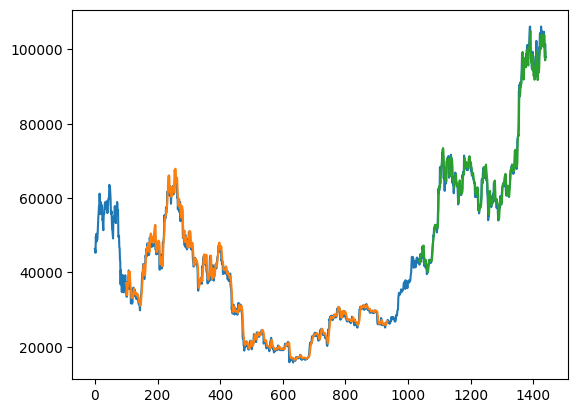

In [60]:
#PLotting : shift train prediction for plotting
look_back = 100
trainPredictPLot = np.empty_like(df3)
trainPredictPLot[:,:] = np.nan
trainPredictPLot[look_back:len(train_predict)+look_back,:] = train_predict

#shift test prediction for plotting
testPredictPlot = np.empty_like(df3)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df3)-1,:] = test_predict

#PLot baseline and predictions
plt.plot(scaler.inverse_transform(df3))
plt.plot(trainPredictPLot)
plt.plot(testPredictPlot)
plt.show()

In [61]:
len(test_data)

505

In [62]:
x_input = test_data[405:].reshape(1,-1)
x_input.shape

(1, 100)

In [63]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [64]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.89849967]
101
1 day input [0.62582562 0.60232421 0.59420289 0.59288203 0.58616742 0.57582298
 0.59314841 0.66246033 0.665545   0.6726239  0.67432863 0.71540394
 0.80754224 0.7996019  0.82679322 0.7917879  0.83299276 0.82825822
 0.81991953 0.82697376 0.8480329  0.86973134 0.91460452 0.92096148
 0.90717926 0.90997984 0.85468036 0.84234024 0.88718344 0.8840074
 0.90436805 0.8928917  0.90177445 0.88610197 0.88686108 0.91809607
 0.89931138 0.93077481 0.9310891  0.9450658  0.90245889 0.89493129
 0.94521249 0.93236792 0.94772047 0.94742366 0.98085003 0.99926534
 0.99982886 0.93353258 0.90293192 0.90722849 0.90118725 0.87768241
 0.87406475 0.91649267 0.92477993 0.88411559 0.8674101  0.87814139
 0.86071462 0.85055216 0.85880225 0.86987062 0.89762037 0.91128079
 0.91214245 0.91361686 0.95715037 0.89807957 0.87715583 0.84946704
 0.87338606 0.87183355 0.87112245 0.87125509 0.89348199 0.93755469
 0.93167596 0.97738292 0.98092724 0.94531747 0.95567397 1.
 0.97249274 0.9754221  0.98560956 0.984264

In [65]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

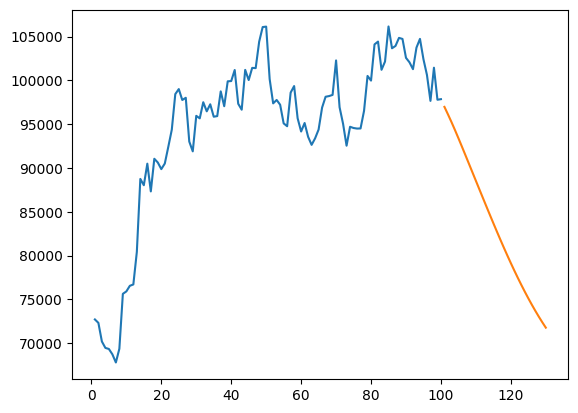

In [66]:
plt.plot(day_new,scaler.inverse_transform(df3[1341:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

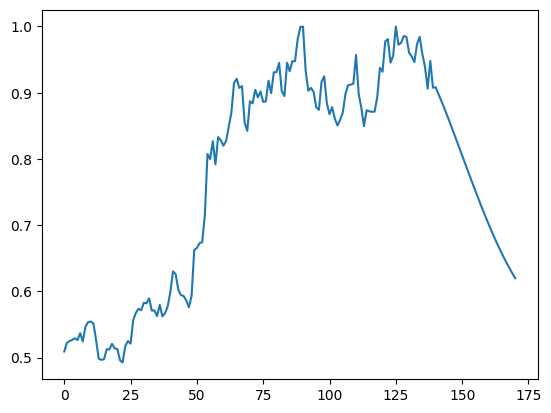

In [67]:
df5=df3.tolist()
df5.extend(lst_output)
plt.plot(df5[1300:])

In [68]:
df5=scaler.inverse_transform(df5).tolist()

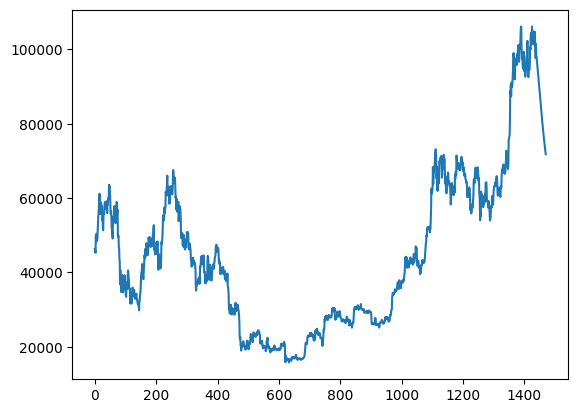

In [69]:
plt.plot(df5)

MLFORECAST

In [70]:
df6 = df[['Date','Close']]

In [71]:
train_size = int(len(df6) * 0.8)
train, test = df6.iloc[:train_size], df6.iloc[train_size:]

print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')

Train set size: 1152
Test set size: 289


In [72]:
train_ = pd.DataFrame({'unique_id':[1]*len(train),'ds': train["Date"], "y":train["Close"]})
test_ = pd.DataFrame({'unique_id':[1]*len(test),'ds': test["Date"], "y":test["Close"]})

In [73]:
# Define metrics functions
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))) * 100

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'LGBMRegressor': lgb.LGBMRegressor(verbosity=-1),
    'XGBRegressor': xgb.XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(random_state=0),
}
@njit
def rolling_mean_7(x):
    return rolling_mean(x, window_size=7)
@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)

# Initialize MLForecast
fcst = MLForecast(
    models=list(models.values()),
    freq='W',
    lags=[7, 14, 28],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_7, rolling_mean_14],
        14: [rolling_mean_7, rolling_mean_14]
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],
    target_transforms=[Differences([7])]
)

# Fit model
fcst.fit(train_)

# Predict
all_predictions = fcst.predict(len(test_))
all_predictions.rename(columns={'ds': 'Date'}, inplace=True)

# Split predictions by model
model_predictions = {model_name: all_predictions[f'{model_name}'] for model_name in models.keys()}

# Create a dictionary to hold metrics for each model
model_metrics = {}

# Evaluate each model
for model_name, y_pred in model_predictions.items():
    mse = mean_squared_error(test_['y'], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_['y'], y_pred)
    
    # Store metrics
    model_metrics[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(model_metrics).T
metrics_df = metrics_df.round(4)  # Round to 4 decimal places for readability

# Display the metrics table
print(metrics_df)

                                MSE        RMSE         MAE
LinearRegression       1.328136e+09  36443.5997  31253.6384
LGBMRegressor          3.644773e+08  19091.2891  12766.8068
XGBRegressor           2.914676e+08  17072.4233  12387.6640
RandomForestRegressor  2.378782e+08  15423.2994  11878.8462


In [74]:
# Save the XGBRegressor model
xgb_model = models['XGBRegressor']

In [75]:
#model_path2 = os.path.join('C:\\Users\\shivi\\OneDrive\\Desktop\\My Projects\\Sneha bitcoin prediction', 'xgb_model.pkl')

In [76]:
#with open(model_path2, 'wb') as file:
    #pickle.dump(xgb_model, file)

TIMEGPT

In [77]:
# 1. Instantiate the NixtlaClient
nixtla_client = NixtlaClient(api_key = 'nixtla-tok-xmAyKHqhIBdxxbi4cHkXXu2QxqAIhzfmykdQw4SkorJjqlO2ZjI5JuDQ0yYiCZplmhaDM0DPbnDbhpMs')

In [78]:
df6.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

if we set the add_history argument of the forecast method to True, TimeGPT will generate predictions for the historical observations too. This can be useful for assessing the model’s performance on the training data.

level: (list) The confidence level for the prediction intervals. Given the inherent volatility of Bitcoin, we will use multiple confidence levels.

In [79]:
level = [50,80,90] # confidence levels 
# h = 30 is the forecast for the next 10 days
fcst = nixtla_client.forecast(df6, h=10, level=level, add_history = True)
fcst.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


,ds,TimeGPT,TimeGPT-hi-50,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-50,TimeGPT-lo-80,TimeGPT-lo-90
0,2021-04-01,58798.547,60827.970,62654.516,63747.630,56769.125,54942.580,53849.465
1,2021-04-02,59186.050,61215.473,63042.020,64135.133,57156.630,55330.082,54236.970
2,2021-04-03,59661.790,61691.210,63517.758,64610.870,57632.367,55805.820,54712.707
3,2021-04-04,59396.758,61426.180,63252.727,64345.840,57367.336,55540.790,54447.676
4,2021-04-05,58838.470,60867.890,62694.438,63787.550,56809.047,54982.500,53889.387


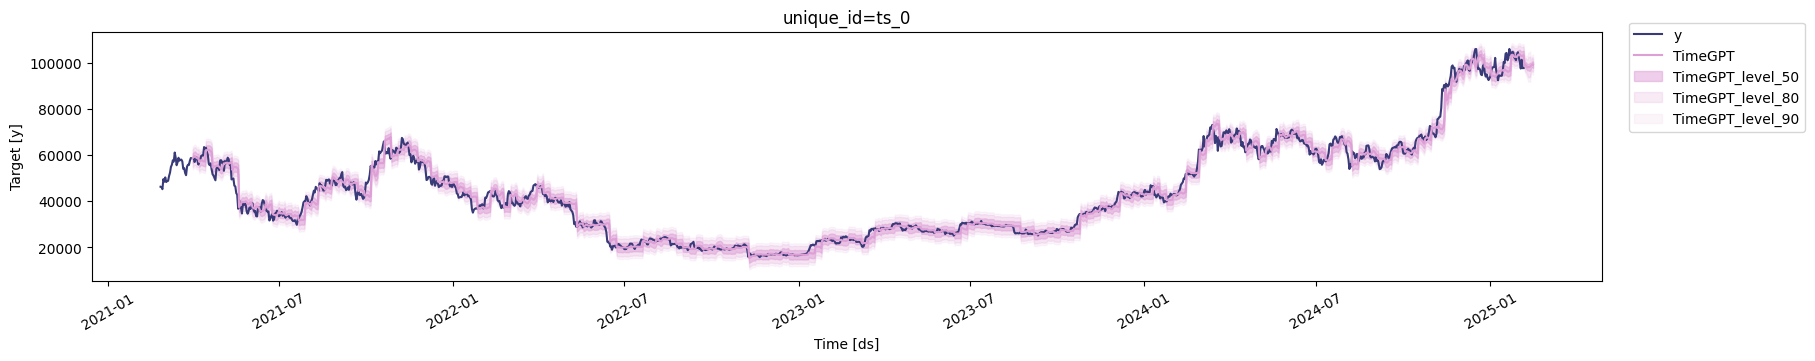

In [80]:
nixtla_client.plot(df6, fcst, level=level)

Given the volatility of the price of Bitcoin, it can be useful to try to identify anomalies in the data. TimeGPT can be used for this by calling the detect_anomalies method from the NixtlaClient class. This method evaluates each observation against its context within the series, using statistical measures to determine its likelihood of being an anomaly. By default, it identifies anomalies based on a 99 percent prediction interval. To change this, you can specify the level argument.

In [81]:
anomalies_df = nixtla_client.detect_anomalies(df6)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


In [82]:
anomalies_df

,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
0,2021-04-01,58730.82,58798.426,66548.630,51048.220,False
1,2021-04-02,58987.80,59185.855,66936.060,51435.650,False
2,2021-04-03,57074.97,59661.590,67411.800,51911.383,False
3,2021-04-04,58219.43,59396.664,67146.875,51646.457,False
4,2021-04-05,59119.56,58838.367,66588.580,51088.160,False
...,...,...,...,...,...,...
1402,2025-02-01,100619.87,103798.720,111548.930,96048.510,False
1403,2025-02-02,97665.06,103211.110,110961.320,95460.900,False
1404,2025-02-03,101451.28,103099.050,110849.260,95348.836,False
1405,2025-02-04,97794.88,103306.960,111057.170,95556.750,False


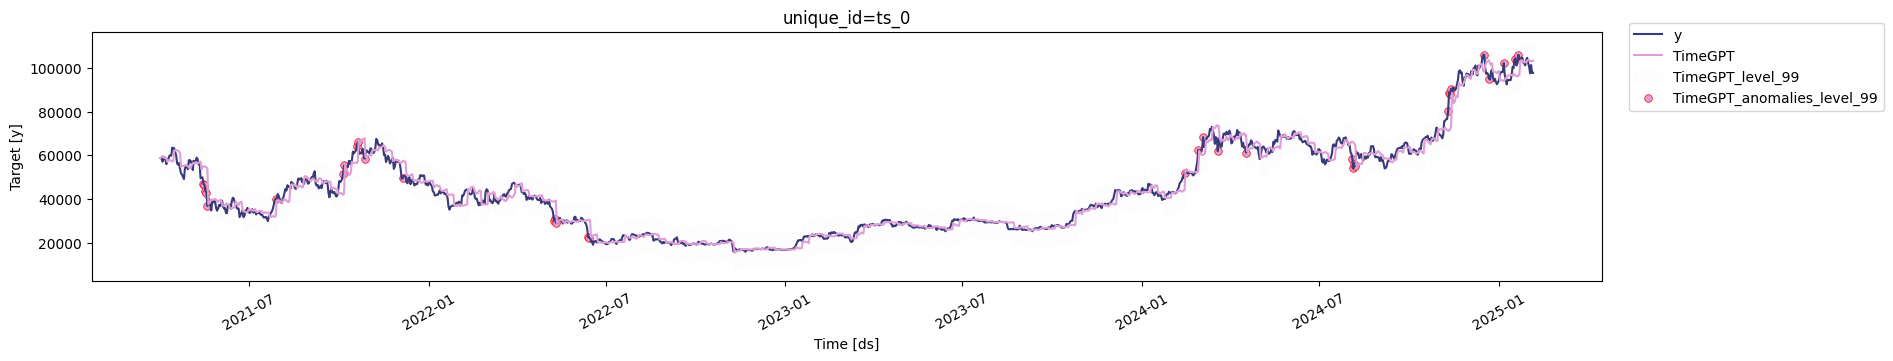

In [83]:
nixtla_client.plot(df6, anomalies_df, plot_anomalies=True)

In [84]:
df6['y'].shape

(1441,)

In [85]:
fcst['TimeGPT']

0       58798.547
1       59186.050
2       59661.790
3       59396.758
4       58838.470
          ...    
1412    98273.010
1413    98499.860
1414    98889.300
1415    99443.086
1416    99334.586
Name: TimeGPT, Length: 1417, dtype: float64

In [86]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))) * 100

# Ensure your actual column name is used
y_true = df6['y'][:1417]  # Replace with the actual column name

# Get TimeGPT predictions
y_pred = fcst['TimeGPT']

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
mdape = median_absolute_percentage_error(y_true, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

# Store metrics
timegpt_metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape,
    'MDAPE': mdape,
    'SMAPE': smape
}

# Print metrics
print(f'Metrics for TimeGPT:')
for metric_name, value in timegpt_metrics.items():
    print(f'  {metric_name}: {value}')


Metrics for TimeGPT:
  MSE: 62894306.21062993
  RMSE: 7930.5930554171
  MAE: 5609.955328158081
  MAPE: 13.349878510000066
  MDAPE: 9.625388085379344
  SMAPE: 12.932662994975052
